#### Import necessary libraries

In [84]:
import pandas as pd
import numpy as np
import joblib
import dask
import dask.dataframe as dd
import dask.array as da

import matplotlib.pyplot as plt
import seaborn as sns
# import hvplot.dask
import altair as alt

# from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score
# from dask_ml.ensemble import RandomForestClassifier
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import DummyEncoder, LabelEncoder
from dask_ml.compose import ColumnTransformer
from xgboost import XGBClassifier, DMatrix  # Import DaskXGBClassifier from xgboost.dask
from dask_ml.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from dask.distributed import Client, progress

In [2]:
# Initialize Dask client
client = Client(n_workers=4, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63617,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.77 GiB
Comm: tcp://127.0.0.1:63636,Total threads: 1
Dashboard: http://127.0.0.1:63641/status,Memory: 3.94 GiB
Nanny: tcp://127.0.0.1:63620,


In [5]:
client.close()

#### Analyses of given DataSet

In [63]:
# Define data types for columns
dtypes = {
    'FL_DATE': 'object',
    'OP_CARRIER': 'object',
    'OP_CARRIER_FL_NUM': 'int64',
    'ORIGIN': 'object',
    'DEST': 'object',
    'CRS_DEP_TIME': 'int64',
    'DEP_TIME': 'float64',
    'DEP_DELAY': 'float64',
    'TAXI_OUT': 'float64',
    'WHEELS_OFF': 'float64',
    'WHEELS_ON': 'float64',
    'TAXI_IN': 'float64',
    'CRS_ARR_TIME': 'int64',
    'ARR_TIME': 'float64',
    'ARR_DELAY': 'float64',
    'CANCELLED': 'float64',
    'CANCELLATION_CODE': 'object',
    'DIVERTED': 'float64',
    'CRS_ELAPSED_TIME': 'float64',
    'ACTUAL_ELAPSED_TIME': 'float64',
    'AIR_TIME': 'float64',
    'DISTANCE': 'float64',
    'CARRIER_DELAY': 'float64',
    'WEATHER_DELAY': 'float64',
    'NAS_DELAY': 'float64',
    'SECURITY_DELAY': 'float64',
    'LATE_AIRCRAFT_DELAY': 'float64',
    'Unnamed: 27': 'object'
}

In [64]:
# Read all csv files with defined data types
# dfs = [dd.read_csv(f'{year}.csv', dtype=dtypes, blocksize='100MB') for year in [2016, 2017, 2018]]

# Concatenate the individual DataFrames
# airline_delays = dd.concat(dfs, interleave_partitions=True)
airline_delays = dd.read_csv('2017.csv', dtype=dtypes, blocksize='100MB')

# # Set the number of partitions
# airline_delays = airline_delays.repartition(partition_size='100MB')

# Drop unnecessary columns
airline_delays = airline_delays.drop(['FL_DATE', 'Unnamed: 27'], axis=1)

# Persist the DataFrame to manage memory usage better
airline_delays = airline_delays.persist()

In [65]:
print(f"Number of partitions: {airline_delays.npartitions}")
airline_delays

Number of partitions: 7


,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
npartitions=7,,,,,,,,,,,,,,,,,,,,,,,,,,
,string,int64,string,string,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,string,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [17]:
# Display the first few rows
airline_delays.head(10)

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,DL,1248,DTW,LAX,1935,1935.0,0.0,23.0,1958.0,2107.0,...,0.0,309.0,285.0,249.0,1979.0,NaN,NaN,NaN,NaN,NaN
1,DL,1251,ATL,GRR,2125,2130.0,5.0,13.0,2143.0,2315.0,...,0.0,116.0,109.0,92.0,640.0,NaN,NaN,NaN,NaN,NaN
2,DL,1254,LAX,ATL,2255,2256.0,1.0,19.0,2315.0,542.0,...,0.0,245.0,231.0,207.0,1947.0,NaN,NaN,NaN,NaN,NaN
3,DL,1255,SLC,ATL,1656,1700.0,4.0,12.0,1712.0,2205.0,...,0.0,213.0,193.0,173.0,1590.0,NaN,NaN,NaN,NaN,NaN
4,DL,1256,BZN,MSP,900,1012.0,72.0,63.0,1115.0,1416.0,...,0.0,136.0,188.0,121.0,874.0,72.0,0.0,52.0,0.0,0.0
5,DL,1257,ATL,BNA,1233,1356.0,83.0,22.0,1418.0,1356.0,...,0.0,66.0,66.0,38.0,214.0,43.0,0.0,0.0,0.0,40.0
6,DL,1257,BNA,ATL,1320,1446.0,86.0,15.0,1501.0,1638.0,...,0.0,70.0,58.0,37.0,214.0,3.0,0.0,0.0,0.0,71.0
7,DL,1258,ATL,JAX,945,946.0,1.0,19.0,1005.0,1050.0,...,0.0,65.0,67.0,45.0,270.0,NaN,NaN,NaN,NaN,NaN
8,DL,1258,JAX,ATL,1145,1144.0,-1.0,12.0,1156.0,1239.0,...,0.0,77.0,63.0,43.0,270.0,NaN,NaN,NaN,NaN,NaN
9,DL,1259,ATL,OKC,2110,2107.0,-3.0,16.0,2123.0,2219.0,...,0.0,146.0,137.0,116.0,761.0,NaN,NaN,NaN,NaN,NaN


In [7]:
# Describe the remaining columns
airline_delays.describe().compute()

,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,1.850572e+07,1.850572e+07,1.824964e+07,1.824469e+07,1.824233e+07,1.824234e+07,1.823396e+07,1.823396e+07,1.850572e+07,1.823396e+07,...,1.850572e+07,1.850570e+07,1.819656e+07,1.819656e+07,1.850572e+07,3.346422e+06,3.346422e+06,3.346422e+06,3.346422e+06,3.346422e+06
mean,2.304636e+03,1.330173e+03,1.333743e+03,9.580880e+00,1.684608e+01,1.356366e+03,1.464456e+03,7.527831e+00,1.488610e+03,1.468884e+03,...,2.379858e-03,1.442253e+02,1.392277e+02,1.148660e+02,8.325811e+02,1.983223e+01,3.085360e+00,1.558675e+01,9.043271e-02,2.511713e+01
std,1.792030e+03,4.905252e+02,5.038671e+02,4.304882e+01,9.441980e+00,5.055427e+02,5.326592e+02,5.909656e+00,5.179178e+02,5.370026e+02,...,4.872571e-02,7.550062e+01,7.503799e+01,7.288150e+01,6.133906e+02,5.952605e+01,2.604034e+01,3.445542e+01,2.929289e+00,4.807805e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,-2.340000e+02,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,-9.900000e+01,1.400000e+01,4.000000e+00,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.164000e+03,9.200000e+02,9.260000e+02,-4.000000e+00,1.200000e+01,9.410000e+02,1.108000e+03,5.000000e+00,1.121000e+03,1.112000e+03,...,0.000000e+00,9.500000e+01,9.000000e+01,6.600000e+01,4.140000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.493000e+03,1.330000e+03,1.338000e+03,0.000000e+00,1.500000e+01,1.351000e+03,1.520000e+03,6.000000e+00,1.530000e+03,1.524000e+03,...,0.000000e+00,1.380000e+02,1.320000e+02,1.060000e+02,7.560000e+02,5.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,1.000000e+01
75%,4.470000e+03,1.745000e+03,1.759000e+03,1.900000e+01,2.100000e+01,1.814000e+03,1.922000e+03,9.000000e+00,1.925000e+03,1.927000e+03,...,0.000000e+00,1.900000e+02,1.850000e+02,1.570000e+02,1.167000e+03,2.300000e+01,0.000000e+00,2.400000e+01,0.000000e+00,4.000000e+01
max,8.402000e+03,2.359000e+03,2.400000e+03,2.755000e+03,1.960000e+02,2.400000e+03,2.400000e+03,4.140000e+02,2.400000e+03,2.400000e+03,...,1.000000e+00,7.180000e+02,7.840000e+02,7.230000e+02,4.983000e+03,2.142000e+03,2.692000e+03,1.848000e+03,9.870000e+02,2.454000e+03


In [66]:
airline_delays.dtypes

OP_CARRIER             string[pyarrow]
OP_CARRIER_FL_NUM                int64
ORIGIN                 string[pyarrow]
DEST                   string[pyarrow]
CRS_DEP_TIME                     int64
DEP_TIME                       float64
DEP_DELAY                      float64
TAXI_OUT                       float64
WHEELS_OFF                     float64
WHEELS_ON                      float64
TAXI_IN                        float64
CRS_ARR_TIME                     int64
ARR_TIME                       float64
ARR_DELAY                      float64
CANCELLED                      float64
CANCELLATION_CODE      string[pyarrow]
DIVERTED                       float64
CRS_ELAPSED_TIME               float64
ACTUAL_ELAPSED_TIME            float64
AIR_TIME                       float64
DISTANCE                       float64
CARRIER_DELAY                  float64
WEATHER_DELAY                  float64
NAS_DELAY                      float64
SECURITY_DELAY                 float64
LATE_AIRCRAFT_DELAY      

In [67]:
# Convert string[pyarrow] and object columns to categorical
categorical_cols = airline_delays.select_dtypes(include=['string[pyarrow]', 'object']).columns
for col in categorical_cols:
    airline_delays[col] = airline_delays[col].astype('category')
    
# Encode categorical columns
le = LabelEncoder()
for col in categorical_cols:
    # Use map_partitions to apply LabelEncoder on each partition
    airline_delays[col] = airline_delays[col].map_partitions(lambda s: le.fit_transform(s.astype(str)))

# Verify that all columns are now numerical
print(airline_delays.dtypes)

OP_CARRIER               int32
OP_CARRIER_FL_NUM        int64
ORIGIN                   int32
DEST                     int32
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE        int32
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
dtype: object


In [86]:
airline_delays.isnull().sum().compute()

OP_CARRIER             0
OP_CARRIER_FL_NUM      0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
TAXI_OUT               0
WHEELS_OFF             0
WHEELS_ON              0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
CANCELLED              0
CANCELLATION_CODE      0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
dtype: int64

In [72]:
airline_delays.head(10)

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
2,0,4,161,152,1130,1221.0,51.0,20.0,1241.0,2025.0,15.0,1958,2040.0,42.0,0.0,4,0.0,328.0,319.0,284.0,2475.0,7.000000,0.000000,0.000000,0.000000,35.000000
3,0,5,76,128,1135,1252.0,77.0,19.0,1311.0,1744.0,5.0,1612,1749.0,97.0,0.0,4,0.0,517.0,537.0,513.0,3784.0,77.000000,0.000000,20.000000,0.000000,0.000000
5,0,7,76,206,940,1619.0,399.0,12.0,1631.0,2031.0,6.0,1403,2037.0,394.0,0.0,4,0.0,503.0,498.0,480.0,3711.0,394.000000,0.000000,0.000000,0.000000,0.000000
14,0,20,261,152,1530,1525.0,-5.0,16.0,1541.0,2319.0,14.0,2357,2333.0,-24.0,0.0,4,0.0,327.0,308.0,278.0,2586.0,19.929325,2.719604,16.028382,0.091474,25.163428
22,0,31,161,128,822,821.0,-1.0,20.0,841.0,1205.0,11.0,1239,1216.0,-23.0,0.0,4,0.0,377.0,355.0,324.0,2556.0,19.929325,2.719604,16.028382,0.091474,25.163428
28,0,38,137,187,1348,1404.0,16.0,10.0,1414.0,1710.0,10.0,1715,1720.0,5.0,0.0,4,0.0,147.0,136.0,116.0,964.0,19.929325,2.719604,16.028382,0.091474,25.163428
38,0,53,211,283,1508,1517.0,9.0,13.0,1530.0,1847.0,6.0,1844,1853.0,9.0,0.0,4,0.0,156.0,156.0,137.0,1012.0,19.929325,2.719604,16.028382,0.091474,25.163428
42,0,58,155,161,2305,2352.0,47.0,12.0,4.0,642.0,7.0,628,649.0,21.0,0.0,4,0.0,323.0,297.0,278.0,2504.0,3.000000,0.000000,0.000000,0.000000,18.000000
56,0,74,76,182,1728,1835.0,67.0,11.0,1846.0,1947.0,4.0,1854,1951.0,57.0,0.0,4,0.0,86.0,76.0,61.0,431.0,0.000000,0.000000,0.000000,0.000000,57.000000
57,0,74,182,76,1934,2022.0,48.0,12.0,2034.0,2143.0,7.0,2120,2150.0,30.0,0.0,4,0.0,106.0,88.0,69.0,431.0,0.000000,0.000000,0.000000,0.000000,30.000000


In [ ]:
# Replace NaNs: For numerical columns, use the mean; for categorical, use the mode
for col, dtype in airline_delays.dtypes.items():
    if dtype == 'category':
        mode_value = airline_delays[col].mode().compute().iloc[0]
        airline_delays[col] = airline_delays[col].fillna(mode_value)
    else:
        mean_value = airline_delays[col].mean().compute()
        airline_delays[col] = airline_delays[col].fillna(mean_value)

# Persist the DataFrame to manage memory usage better
airline_delays = airline_delays.persist()

In [26]:
if isinstance(airline_delays, dd.DataFrame):
    print("airline_delays is a Dask DataFrame")
else:
    print("airline_delays is not a Dask DataFrame")

airline_delays is a Dask DataFrame


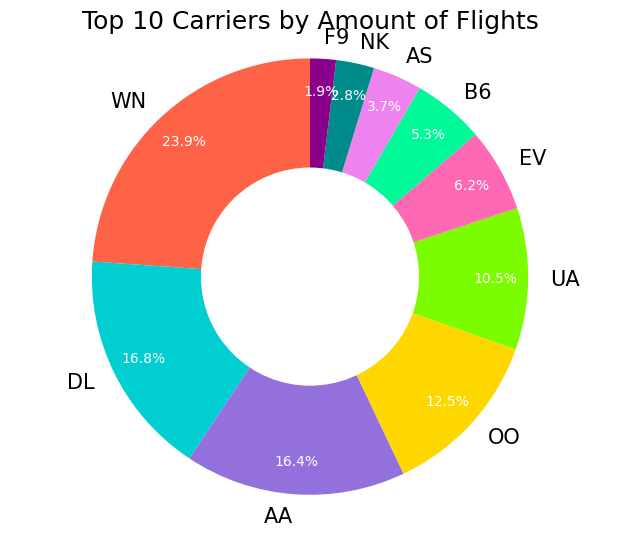

In [9]:
# Group by airline and count the occurrences
carrier_counts = airline_delays.groupby('OP_CARRIER').size().compute().reset_index()
carrier_counts.columns = ['Carrier', 'count']

# Sort the carrier counts in descending order and select the top 10
top_10 = carrier_counts.sort_values('count', ascending=False).head(10)

# Create a pie chart
carriers = top_10['Carrier'].tolist()
counts = top_10['count'].tolist()

# Define a custom list of colors
custom_colors = ['#FF6347', '#00CED1', '#9370DB', '#FFD700', '#7CFC00', '#FF69B4', '#00FA9A', '#EE82EE', '#008B8B', '#8B008B']

fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(counts, labels=carriers, autopct='%1.1f%%', startangle=90,
                                  pctdistance=0.85, textprops=dict(size=10, color='black'),
                                  colors=custom_colors)

# Adjust aspect ratio
ax.axis('equal')

# Add a title
ax.set_title('Top 10 Carriers by Amount of Flights', size=18)

# Create a circle at the center for a better visualization
center_circle = plt.Circle((0, 0), 0.5, fc='white')
ax.add_artist(center_circle)

# Adjust the position of the text labels
for text in texts:
    text.set_fontsize(15)
    text.set_color('black')

for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('white')

# Adjust spacing between the pie and text labels
plt.gcf().subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9)

plt.show()

In [10]:
# Filter rows where CANCELLATION_CODE is not null
airline_delays_filtered = airline_delays[airline_delays['CANCELLATION_CODE'].notnull()]

# Encode the CANCELLATION_CODE column
airline_delays_filtered['CANCELLATION_CODE'] = airline_delays_filtered['CANCELLATION_CODE'].replace({
    'A': 'By carrier',
    'B': 'Due to weather',
    'C': 'By national air system',
    'D': 'For security'
})

# Count the number of cancellations per code/reason
cancellation_counts = airline_delays_filtered.groupby('CANCELLATION_CODE').size().compute().reset_index()
cancellation_counts.columns = ['CANCELLATION_CODE', 'count']

# Rename cancellation code values
cancellation_counts['CANCELLATION_CODE'] = cancellation_counts['CANCELLATION_CODE'].replace({
    'A': 'By carrier',
    'B': 'Due to weather',
    'C': 'By national air system',
    'D': 'For security'
})

# Rename the column
cancellation_counts = cancellation_counts.rename(columns={'CANCELLATION_CODE': 'Reason'})

# Convert to Pandas DataFrame for visualization
cancellation_reasons = pd.DataFrame(cancellation_counts)

# Visualization of cancellation reasons
chart = alt.Chart(cancellation_reasons).mark_arc(outerRadius=180, innerRadius=50).encode(
    theta=alt.Theta(field="count", type="quantitative", stack=True),
    color=alt.Color('Reason:N', scale=alt.Scale(scheme='category20'), legend=None),
).properties(
    title='Reasons for flight cancellations',
    width=600,
    height=300
)

pie = chart.mark_arc(outerRadius=250)
value_text = pie.mark_text(radius=220, size=15).encode(text=alt.Text('count:Q'))

pie2 = chart.mark_arc(outerRadius=150)
text = pie2.mark_text(radius=120, size=15).encode(
    text=alt.Text('Reason:N'),
    color=alt.value("#ffffff")
)

final_chart = (chart + text + value_text).configure_view(
    strokeWidth=0
).configure_title(
    fontSize=18
)

# Display the chart
final_chart.display()

alt.LayerChart(...)

NEW TRY (CORRECT MODEL TRAINING)

In [73]:
# Convert the DataFrame to a Dask Array
airline_delays_array = airline_delays.to_dask_array(lengths=True)

# Split the array into features and target
X_array = airline_delays_array[:, :-1]
y_array = airline_delays_array[:, -1]

In [74]:
# # Split the data into features and target
# X = airline_delays_array.drop('ARR_DELAY', axis=1)
# y = airline_delays_array['ARR_DELAY']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42, shuffle=True)

In [75]:
y_test_series = pd.Series(y_test)
y_test_series.tail(15)

1134911    25.163428
1134912    25.163428
1134913    25.163428
1134914    25.163428
1134915    25.163428
1134916     0.000000
1134917    33.000000
1134918    25.163428
1134919    25.163428
1134920    25.163428
1134921     0.000000
1134922     0.000000
1134923     0.000000
1134924    25.163428
1134925    25.163428
dtype: float64

In [76]:
# Train the Linear Regression model
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

# Predict and evaluate
y_pred = linear_regression.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Optionally, shut down the Dask client after processing
# client.close()

Mean Squared Error: 232.33042718381543


In [78]:
# Calculate the mean of the training target values
y_train_mean = y_train.mean().compute()

# Predict the mean for all test instances
y_baseline_pred = da.full_like(y_test, y_train_mean)

# Compute the MSE for the baseline model
baseline_mse = mean_squared_error(y_test, y_baseline_pred)
print(f"Baseline Mean Squared Error: {baseline_mse}")

Baseline Mean Squared Error: 413.63374236341076


In [85]:
# Compute Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Compute R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

Mean Absolute Error: 8.733623097076162
R-squared: 0.4383160598324972


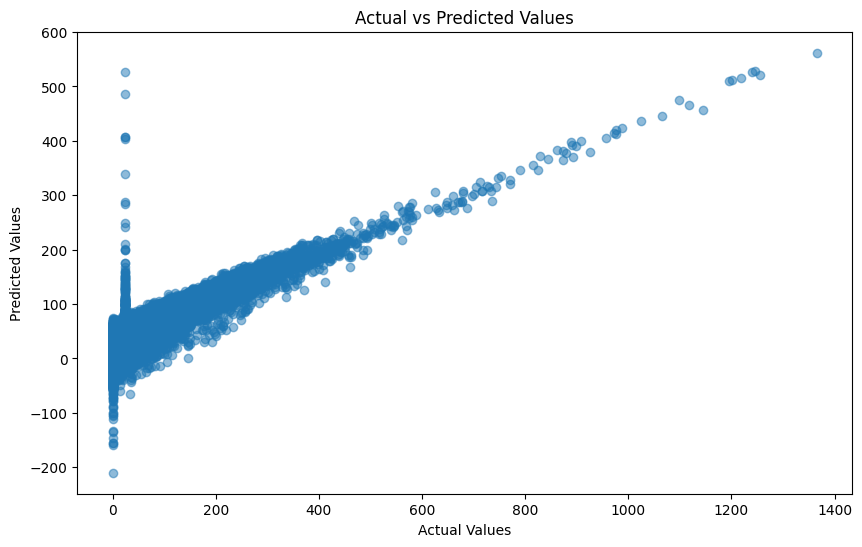

In [83]:
# Compute values for plotting
y_test_values = y_test.compute()
y_pred_values = y_pred.compute()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_values, y_pred_values, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()